In [3]:
import math 
import os
import re
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from concurrent.futures import ThreadPoolExecutor
from os import listdir
from os.path import isfile, join
from random import sample
from scipy.spatial import distance
from scipy.cluster import hierarchy as hc
from scipy.linalg import sqrtm, block_diag, pinvh, eigh
from numpy.linalg import inv, pinv
from numpy.random import normal, poisson, randint
from numpy import diagflat, eye, fill_diagonal, diag, sqrt
from sklearn.utils import resample

from aux_functions import *

In [6]:
def process_graph():
    graph = genWG(d=d, p11=.8, p22=.7, p12=.3, lam11=20, lam22=15, lam12=6)
    return graph + np.ones((d, d))

# Experiments

In [17]:
d = 40 # размерность матриц
Nn = 8000  # размер популяции

population_graphs = [] 
with ThreadPoolExecutor() as executor:
    population_graphs = list(executor.map(lambda _: process_graph(), range(Nn)))
       
    
population = [] # large sample to copmute the true barycenter

W = GenONbasisVec(d) #ON basis for projection of GL
for p in population_graphs:
    population.append(genGLFast(p, W)) #compute and project GL


    
fm = Fbarycenter(population)
bw = Wbarycenter(population, init = fm, verbose = True, max_iterations = 10)  # вычисление барицентра

1 0.03487441459270991
2 0.00016183931824658872
Success! Iterations number: 2


In [25]:
#True distribution
n = 100# observed sample
Mm = 1000
bw_true = []
for m in range(Mm):
    sub_population = subsmple(population, n, repl = False)
    M_emp = Fbarycenter(sub_population)
    bw_emp =  Wbarycenter(sub_population, init = M_emp)
    bw_true.append(BW(bw_emp, bw) * np.sqrt(n))
    
np.save('bw_true_d{0}_n{1}_M{2}_L_proj.npy'.format(d, n, Mm), bw_true)

In [26]:
basis_test = GenONbasis(np.shape(bw)[0])
#Bootstrap
Mmm = 100
N = 1000
stat_bw_boot = []

for mm in range(Mmm):
    print(mm)
    stat_bw = []
    s_sample = subsmple(population, n, repl = False)
    Qqq = Fbarycenter(s_sample)
    bw_emp = Wbarycenter(s_sample, init = Qqq)
    for i in range(N):
        w = [0, 0]
        while (sum(w) == 0):
            w = 2*np.random.binomial(n=1, p=1/2, size=n) 
            
        Qq = Fbarycenter(s_sample, w)
        bw_N = Wbarycenter(s_sample, w, init = Qq)
        stat_bw.append(BW(bw_emp, bw_N) * np.sqrt(n))
    
    stat_bw_boot.append(stat_bw)
    
np.save('stat_bw_boot_d{0}_n{1}_M{2}_L_proj.npy'.format(d, n, N), stat_bw_boot)

#Resamapling for asumptotic curve

stat_bw_rsmp = []
g = int(np.shape(bw)[0] * (np.shape(bw)[0] + 1) / 2)  # размерность базиса
for mm in range(Mmm):
    print(mm)
    stat_rsmp = []
    s_sample = subsmple(population, n, repl = False)
    Qqq = Fbarycenter(s_sample)
    bw_emp = Wbarycenter(s_sample, init = Qqq)
    
    
    sub_population_rsmp = subsmple(s_sample, n, repl = True)
    M_emp_rsmp = Fbarycenter(sub_population_rsmp)

    bw_rsmp =  Wbarycenter(sub_population_rsmp, init = M_emp_rsmp, verbose = False)

            #     Вычисляем \frac{1}{n}\sum_i[dT^{S_i}_{Q_n}]
    dT = np.zeros((g, g))  
                
    for i in range(n):
        dT_aux = ComputeReprdT(bw_rsmp, sub_population_rsmp[i],  basis = basis_test)
        dT += dT_aux
    dT /= n


    inv_mean_dT = MInv(dT) #-F^{-1}_n

    # Вычисление дисперсии T
    var_T = np.zeros((g, g))
    identity = np.eye(np.shape(bw)[0])
    for i in range(n):
        ot_map = GetOTmap(bw_rsmp, sub_population_rsmp[i])
        vec_T = GetRepr(ot_map - identity, basis = basis_test)
        var_T += np.outer(vec_T, vec_T)

    var_T /= n

    # Вычисляем ковариацию Uξ
    upxi1 = inv_mean_dT @ var_T @ inv_mean_dT #Upxi_n
    upx_dummy = sqrtm1(upxi1)

#     uppxi = inv(upx_dummy)
    Qu = ComputeReprdT(bw_rsmp, basis = basis_test)

    for i in range(N):
        Z = np.random.normal(0, 1, g)  
        Z_new = upx_dummy @ Z
        Zz_new = Qu @ Z_new
        Tt = np.linalg.norm( sqrtm1(bw_rsmp)@Reconstruct(Zz_new, basis = basis_test), 'fro')

#         print(Tt)
        stat_rsmp.append(Tt)
#         print(en-st)
        
    stat_bw_rsmp.append(stat_rsmp)
    
np.save('stat_bw_boot_d{0}_n{1}_M{2}_emp_L_proj.npy'.format(d, n, N), stat_bw_rsmp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [30]:
x_grid = np.linspace(0.01,0.08, 1000) 

curves = []
qq1 = stat_bw_boot
for i in range(len(qq1)):
    A1 = ecdf_on_grid(qq1[i], x_grid)
    curves.append(A1)
    
    
# x_grid = np.linspace(0.05, 0.8, 1000) 
curves_rsmp = []
qq2 = stat_bw_rsmp
for i in range(len(qq2)):
    A2 = ecdf_on_grid(qq2[i], x_grid)
    curves_rsmp.append(A2)
    
true_A = ecdf_on_grid(bw_true, x_grid)

ks_stat_rsmp = []
for i in curves_rsmp:
    ks_stat_rsmp.append(ks_stat_naive(true_A, i))
    
    
ks_stat_boot = []
for i in curves:
    ks_stat_boot.append(ks_stat_naive(true_A, i))

    


KS_var_asm = ceil_to_decimals(np.var(ks_stat_rsmp), 4)

KS_mean_asm = ceil_to_decimals(np.mean(ks_stat_rsmp), 2)

KS_var_boot = ceil_to_decimals(np.var(ks_stat_boot), 4)  
KS_mean_boot = ceil_to_decimals(np.mean(ks_stat_boot), 2)   

In [28]:
result = ceil_to_decimals(KS_var_asm, 4)  # Ceil to 2 decimal places
print(result)  

result = ceil_to_decimals(KS_var_boot, 4)  # Ceil to 2 decimal places
print(result)  

0.0006
0.0005


# Plots

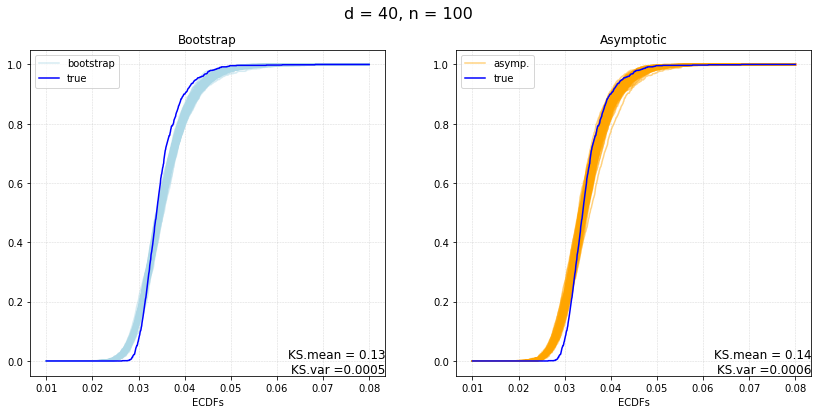

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


for i in range(len(curves)):  
    if (i == 1):
        axes[0].plot(x_grid, curves[i], c='lightblue', alpha = .5, label='bootstrap')
    else:
        axes[0].plot(x_grid, curves[i], c = 'lightblue', alpha = .5)
        

axes[0].plot(x_grid, true_A, c = 'blue', label='true', lw = 1.5)

axes[0].set_title("Bootstrap")
axes[0].set_xlabel("ECDFs")
# axes[0].set_ylabel("sin(x)")
axes[0].legend(loc='best')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid
xlim1 = axes[0].get_xlim()
ylim1 = axes[0].get_ylim()

# Place text in the lower-right corner of the first plot
axes[0].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_boot, KS_var_boot), fontsize=12, color='black', 
             ha='right', va='bottom')


for i in range(len(curves_rsmp)):  
    if (i == len(curves_rsmp) - 1):
        axes[1].plot(x_grid, curves_rsmp[i], c='orange', alpha = .5, label='asymp.')
    else:
        axes[1].plot(x_grid, curves_rsmp[i], c = 'orange', alpha = .5)

axes[1].plot(x_grid, true_A, c = 'blue', label='true', lw = 1.5)
axes[1].set_title("Asymptotic")
axes[1].set_xlabel("ECDFs")
# axes[0].set_ylabel("sin(x)")
axes[1].legend(loc='best')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid

# Place text in the lower-right corner of the first plot
axes[1].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_asm, KS_var_asm), fontsize=12, color='black', 
             ha='right', va='bottom')



fig.suptitle("d = {0}, n = {1}".format(d, n), fontsize=16)

plt.savefig("imgs/boot_cdfs_d={0}_n={1}_L_proj.png".format(d, n), dpi=300, quality=50)